# Follower network
We start from the Twitter follower network constructed for the paper [Right and left, partisanship predicts (asymmetric) vulnerability to misinformation](http://doi.org/10.37016/mr-2020-55). The following data files are available at https://doi.org/10.7910/DVN/6CZHH5:
* `anonymized-friends.json` 
* `measures.tab`

Briefly, this network was constructed as follows:
* We collected all tweets containing links (URLs) from a 10% random sample of public posts between June 1 and June 30, 2017, through the Twitter Decahose. 
* We selected all accounts that shared at least ten links from a set of news sources with known political valence (Bakshy et al., 2015). 
* We further selected those who shared at least one link from a source labeled as low-quality (https://github.com/BigMcLargeHuge/opensources). 
* We excluded likely bot accounts according to the BotometerLite classifier (Yang et al., 2020).

We keep the nodes with both partisanship and misinformation attributes, then we take the core of the network with approximately 10k nodes, and finally remove a random sample of edges to preserve the original average in/out-degree (number of friends/followers).

In [5]:
import networkx as nx
import csv
import json
import random
import importlib
import bot_model
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = "../EmpiricalNet_followers/"

In [13]:
# File has 3 columns: ID \t partisanship \t misinformation \n
partisanship = {}
misinformation = {}
with open(path + "measures.tab") as fd:
    rd = csv.reader(fd, delimiter="\t")
    next(rd) # skip header row
    for row in rd:
        partisanship[int(row[0])] = row[1]
        misinformation[int(row[0])] = row[2]

In [14]:
with open(path + 'anonymized-friends.json') as fp:
    adjlist = json.load(fp)

In [15]:
G = nx.DiGraph() 

In [16]:
# Directed network follower -> friend
for s in adjlist:
    n = int(s)
    if n in partisanship and n in misinformation:
        G.add_node(n, party=partisanship[n], misinfo=misinformation[n]) 
        for f in adjlist[s]:
            G.add_edge(n,f)

In [17]:
average_friends = G.number_of_edges() / G.number_of_nodes()
print("{} nodes and {} edges initially, with average number of friends {}".format(G.number_of_nodes(), G.number_of_edges(), average_friends))
friends = nx.subgraph(G, partisanship.keys())
print("{} nodes and {} edges after filtering".format(friends.number_of_nodes(), friends.number_of_edges()))

58048 nodes and 10499218 edges initially, with average number of friends 180.87131339581038
15056 nodes and 4327448 edges after filtering


In [19]:
# k-core decomposition until ~ 10k nodes in core
core_number = nx.core_number(friends)
nodes = friends.number_of_nodes()
k = 0
while nodes > 10000:
    k_core = nx.k_core(friends, k, core_number)
    nodes = k_core.number_of_nodes()
    k += 10
while nodes < 10000:
    k_core = nx.k_core(friends, k, core_number)
    nodes = k_core.number_of_nodes()
    k -= 1
print("{}-core has {} nodes, {} edges".format(k, k_core.number_of_nodes(), k_core.number_of_edges()))

94-core has 10006 nodes, 4144687 edges


In [20]:
# the network is super dense, so let us delete a random sample of edges
# we can set the initial average in/out-degree (average_friends) as a target 
friends_core = k_core.copy()
edges_to_keep = int(friends_core.number_of_nodes() * average_friends)
edges_to_delete = friends_core.number_of_edges() - edges_to_keep
deleted_edges = random.sample(friends_core.edges(), edges_to_delete)
friends_core.remove_edges_from(deleted_edges)
print("{}-core after edge-sampling has {} nodes, {} edges, and average number of friends {}".format(k, friends_core.number_of_nodes(), friends_core.number_of_edges(), friends_core.number_of_edges() / friends_core.number_of_nodes()))

94-core after edge-sampling has 10006 nodes, 1809798 edges, and average number of friends 180.8712772336598


In [22]:
nx.write_gml(friends_core, path + 'follower_network.gml')

## Baseline (defaults)

In [9]:
# baseline:  mu=0.5, alpha=15, beta=0.01, gamma=0.001, phi=1, theta=1

follower_net = bot_model.init_net(False, verbose=False, human_network = path + 'follower_network.gml', beta=0.01, gamma=0.001)
avg_quality = bot_model.simulation(False, network=follower_net, verbose=False, mu=0.5, phi=1, alpha=15)
print('average quality for follower network:', avg_quality)

average quality for follower network: 0.5077075594573657


## Baseline (no bots)

In [7]:
# baseline:  mu=0.5, alpha=15, beta=0, gamma=0, phi=1, theta=1

follower_net = bot_model.init_net(False, verbose=False, human_network = path + 'follower_network.gml', beta=0.0, gamma=0.0)
avg_quality_baseline = bot_model.simulation(False, network=follower_net, verbose=False, mu=0.5, phi=1, alpha=15)
print('average quality baseline:', avg_quality_baseline)

average quality baseline: 0.5085973526849629


## Experiments with individual parameters
Params: alpha (15), beta (0.01), gamma (0.001), phi (1), theta (1), network density?

In [56]:
# run this when making changes to bot_model.py
importlib.reload(bot_model)

<module 'bot_model' from '/geode2/home/u030/fil/Carbonate/Xiaodan/Manipulating-Online-Marketplace-of-Ideas/bot_model.py'>

### Experiment: alpha (attention)

In [10]:
# alpha=15 from test above
bot_model.save_csv([15, 0.5], csvfile = path + 'alpha.csv')

In [11]:
follower_net = bot_model.init_net(False, human_network = path + 'follower_network.gml', beta=0.01, gamma=0.001)
for alpha in [2, 4, 8, 16, 32, 64, 128]:
    avg_quality = bot_model.simulation(False, network=follower_net, verbose=False, mu=0.5, phi=1, alpha=alpha)
    print('alpha = {}, average quality = {}'.format(alpha, avg_quality))
    bot_model.save_csv([alpha, avg_quality], csvfile = path + 'alpha.csv')

alpha = 2, average quality = 0.4104844503378989
alpha = 4, average quality = 0.45192216668614504
alpha = 8, average quality = 0.4828670416821904
alpha = 16, average quality = 0.49085422998202843
alpha = 32, average quality = 0.4897311274066018
alpha = 64, average quality = 0.4956277033791163
alpha = 128, average quality = 0.4952703802415169


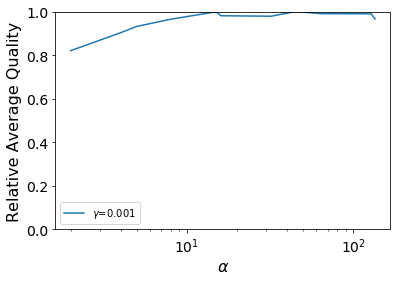

In [17]:
# PLOT AVG_Q vs ALPHA (attention)
bot_model.plot_avg_quality(['alpha.csv'], 
                 [r'$\gamma$=0.001'], 
                 r'$\alpha$', path='../EmpiricalNet_followers/', log_flag=True)

### Experiment: beta (number of bots)

In [ ]:
# beta=0.01 from test above
bot_model.save_csv([0.01, 0.5], csvfile = path + 'beta.csv')
for beta in [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.02, 0.05, 0.1, 0.2, 0.5]:
    follower_net = bot_model.init_net(False, human_network = path + 'follower_network.gml', beta=beta, gamma=0.001)
    avg_quality = bot_model.simulation(False, network=follower_net, verbose=False, mu=0.5, phi=1, alpha=15)
    print('beta = {}, average quality = {}'.format(beta, avg_quality))
    bot_model.save_csv([beta, avg_quality], csvfile = path + 'beta.csv')

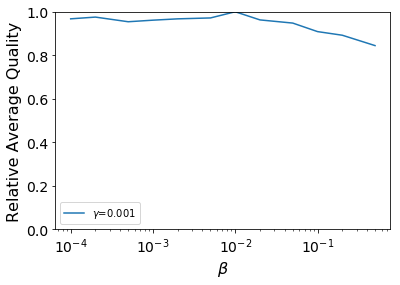

In [21]:
# PLOT AVG_Q vs BETA (number of bots)
bot_model.plot_avg_quality(['beta.csv'], 
                 [r'$\gamma$=0.001'], 
                 r'$\beta$', path='../EmpiricalNet_followers/', log_flag=True)

### Experiment: gamma (infiltration)

In [20]:
# gamma=0.001 from test above
bot_model.save_csv([0.001, 0.5], csvfile = path + 'gamma.csv')
for gamma in [0.0001, 0.0002, 0.0005, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]:
    follower_net = bot_model.init_net(False, human_network = path + 'follower_network.gml', beta=0.01, gamma=gamma)
    avg_quality = bot_model.simulation(False, network=follower_net, verbose=False, mu=0.5, phi=1, alpha=15)
    print('gamma = {}, average quality = {}'.format(gamma, avg_quality))
    bot_model.save_csv([gamma, avg_quality], csvfile = path + 'gamma.csv')

gamma = 0.0001, average quality = 0.4825607552212207
gamma = 0.0002, average quality = 0.4865925582032537
gamma = 0.0005, average quality = 0.4942468782415124
gamma = 0.002, average quality = 0.4773814347822912
gamma = 0.005, average quality = 0.462011508687371
gamma = 0.01, average quality = 0.43985225132767325
gamma = 0.02, average quality = 0.449731319401114
gamma = 0.05, average quality = 0.39336921185379714
gamma = 0.1, average quality = 0.3496314680845976
gamma = 0.2, average quality = 0.2899884642895524
gamma = 0.5, average quality = 0.20544069484892832


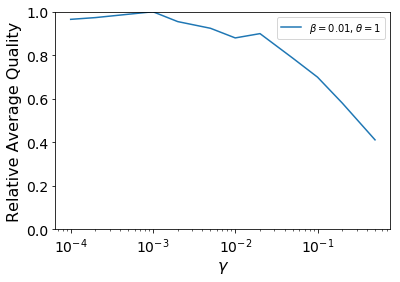

In [22]:
# PLOT AVG_Q vs GAMMA (infiltration)
bot_model.plot_avg_quality(['gamma.csv'], 
                 [r'$\beta=0.01, \theta=1$'], 
                 r'$\gamma$', path='../EmpiricalNet_followers/', log_flag=True)

### Experiment: phi (deception) 

In [24]:
# phi=1 from test above
bot_model.save_csv([1, 0.5], csvfile = path + 'phi.csv')
follower_net = bot_model.init_net(False, human_network = path + 'follower_network.gml', beta=0.01, gamma=0.001)
for phi in [2,4,8,16,32]:
    avg_quality = bot_model.simulation(False, network=follower_net, verbose=False, mu=0.5, phi=phi, alpha=15)
    print('phi = {}, average quality = {}'.format(phi, avg_quality))
    bot_model.save_csv([phi, avg_quality], csvfile = path + 'phi.csv')

phi = 2, average quality = 0.3222070574531627
phi = 4, average quality = 0.13648325135178846
phi = 8, average quality = 0.06611473682738009
phi = 16, average quality = 0.03116847668790619
phi = 32, average quality = 0.01574402161173473


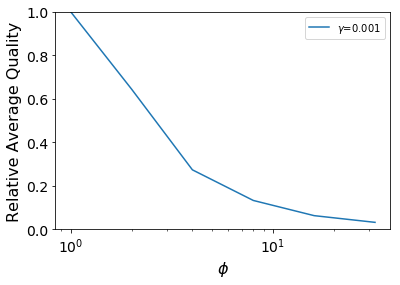

In [42]:
# PLOT AVG_Q vs PHI (deception)
bot_model.plot_avg_quality(['phi.csv'], 
                 [r'$\gamma$=0.001'], 
                 r'$\phi$', path='../EmpiricalNet_followers/', log_flag=True)

### Experiment: theta (flooding)
Effect visible with larger gamma? Saturation with high theta?

In [27]:
# theta=1 from test above
bot_model.save_csv([1, 0.5], csvfile = path + 'theta.csv')
follower_net = bot_model.init_net(False, human_network = path + 'follower_network.gml', beta=0.01, gamma=0.001)
for theta in [2,4,6,8,10,12,14]:
    avg_quality = bot_model.simulation(False, network=follower_net, verbose=False, mu=0.5, phi=1, alpha=15, theta=theta)
    print('theta = {}, average quality = {}'.format(theta, avg_quality))
    bot_model.save_csv([theta, avg_quality], csvfile = path + 'theta.csv')

theta = 2, average quality = 0.4824278556208058
theta = 4, average quality = 0.47214872302651467
theta = 6, average quality = 0.47467459219296937
theta = 8, average quality = 0.49302939753444097
theta = 10, average quality = 0.4754849774091284
theta = 12, average quality = 0.5021458916243314
theta = 14, average quality = 0.4727439306995538


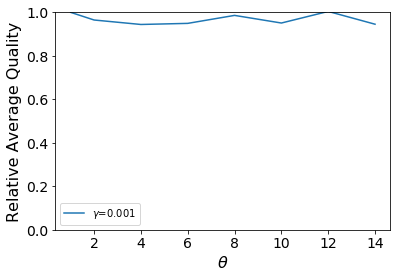

In [28]:
# PLOT AVG_Q vs THETA (flooding)
bot_model.plot_avg_quality(['theta.csv'], 
                 [r'$\gamma$=0.001'], 
                 r'$\theta$', path='../EmpiricalNet_followers/')

## Experiments with parameter interactions
Stronger effects observed above for gamma, phi, theta

### Quality vs theta for increasing values of gamma

In [30]:
# gamma = 0.01
follower_net = bot_model.init_net(False, human_network = path + 'follower_network.gml', beta=0.01, gamma=0.01)
for theta in [1,2,4,6,8,10,12,14]:
    avg_quality = bot_model.simulation(False, network=follower_net, verbose=False, mu=0.5, phi=1, alpha=15, theta=theta)
    print('theta = {}, average quality = {}'.format(theta, avg_quality))
    bot_model.save_csv([theta, avg_quality], csvfile = path + 'theta_gamma0.01.csv')

theta = 1, average quality = 0.4774042555793284
theta = 2, average quality = 0.44062491782939295
theta = 4, average quality = 0.4384923062866867
theta = 6, average quality = 0.4028061001334483
theta = 8, average quality = 0.41379069133829416
theta = 10, average quality = 0.40774968333560946
theta = 12, average quality = 0.40047368636873387
theta = 14, average quality = 0.40768263190549237


In [31]:
# gamma = 0.1
follower_net = bot_model.init_net(False, human_network = path + 'follower_network.gml', beta=0.01, gamma=0.1)
for theta in [1,2,4,6,8,10,12,14]:
    avg_quality = bot_model.simulation(False, network=follower_net, verbose=False, mu=0.5, phi=1, alpha=15, theta=theta)
    print('theta = {}, average quality = {}'.format(theta, avg_quality))
    bot_model.save_csv([theta, avg_quality], csvfile = path + 'theta_gamma0.1.csv')

theta = 1, average quality = 0.3541160115767696
theta = 2, average quality = 0.3318008795084503
theta = 4, average quality = 0.25562390278891567
theta = 6, average quality = 0.21589411837344366
theta = 8, average quality = 0.22642616029401783
theta = 10, average quality = 0.17799595167620857
theta = 12, average quality = 0.17556390569618782
theta = 14, average quality = 0.1687847161795396


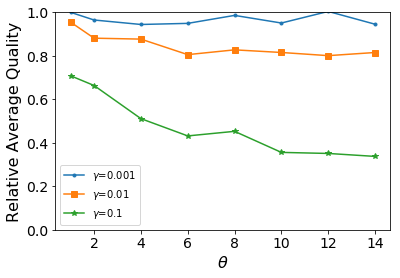

In [54]:
# PLOT AVG_Q vs THETA (flooding)
bot_model.plot_avg_quality(['theta.csv', 'theta_gamma0.01.csv', 'theta_gamma0.1.csv'], 
                 [r'$\gamma$=0.001', r'$\gamma$=0.01', r'$\gamma$=0.1'], 
                 r'$\theta$', path='../EmpiricalNet_followers/')

### Quality vs phi for increasing values of gamma

In [33]:
# gamma = 0.01
follower_net = bot_model.init_net(False, human_network = path + 'follower_network.gml', beta=0.01, gamma=0.01)
for phi in [1,2,4,8,16,32]:
    avg_quality = bot_model.simulation(False, network=follower_net, verbose=False, mu=0.5, phi=phi, alpha=15)
    print('phi = {}, average quality = {}'.format(phi, avg_quality))
    bot_model.save_csv([phi, avg_quality], csvfile = path + 'phi_gamma0.01.csv')

phi = 1, average quality = 0.45202809043261466
phi = 2, average quality = 0.3244971227453973
phi = 4, average quality = 0.13090664217119194
phi = 8, average quality = 0.06454995564328547
phi = 16, average quality = 0.034072435354329945
phi = 32, average quality = 0.015668344728856556


In [34]:
# gamma = 0.1
follower_net = bot_model.init_net(False, human_network = path + 'follower_network.gml', beta=0.01, gamma=0.1)
for phi in [1,2,4,8,16,32]:
    avg_quality = bot_model.simulation(False, network=follower_net, verbose=False, mu=0.5, phi=phi, alpha=15)
    print('phi = {}, average quality = {}'.format(phi, avg_quality))
    bot_model.save_csv([phi, avg_quality], csvfile = path + 'phi_gamma0.1.csv')

phi = 1, average quality = 0.3660336846031876
phi = 2, average quality = 0.24532185132820028
phi = 4, average quality = 0.11667897682102454
phi = 8, average quality = 0.056518083079799775
phi = 16, average quality = 0.028114628404599974
phi = 32, average quality = 0.013985228297865495


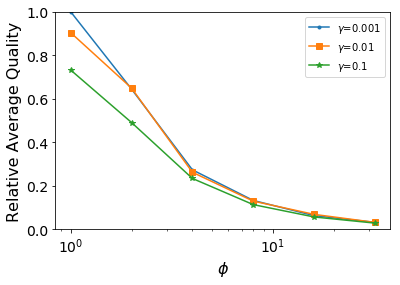

In [53]:
# PLOT AVG_Q vs PHI (deception)
bot_model.plot_avg_quality(['phi.csv', 'phi_gamma0.01.csv', 'phi_gamma0.1.csv'], 
                 [r'$\gamma$=0.001', r'$\gamma$=0.01', r'$\gamma$=0.1'], 
                 r'$\phi$', path='../EmpiricalNet_followers/', log_flag=True)

## Experiments with targeting
Preferential targerting of bot followers: hubs, partisans, conservatives, misinfo spreaders, core?

In [ ]:
# phi=2, theta=5, vary gamma

# no targeting 
for gamma in [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]:
    follower_net = bot_model.init_net(False, human_network = path + 'follower_network.gml', beta=0.01, gamma=gamma)
    avg_quality = bot_model.simulation(False, network=follower_net, verbose=False, mu=0.5, phi=2, alpha=15, theta=5)    
    print('no targeting: gamma = {}, average quality = {}'.format(gamma, avg_quality))
    bot_model.save_csv([gamma, avg_quality], csvfile = path + 'gamma_random.csv')

# targeting hubs (influentials)
for gamma in [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]:
    follower_net = bot_model.init_net(True, targeting_criterion='hubs', human_network = path + 'follower_network.gml', beta=0.01, gamma=gamma)
    avg_quality = bot_model.simulation(True, network=follower_net, verbose=False, mu=0.5, phi=2, alpha=15, theta=5)    
    print('targeting hubs: gamma = {}, average quality = {}'.format(gamma, avg_quality))
    bot_model.save_csv([gamma, avg_quality], csvfile = path + 'gamma_hubs.csv')

# targeting partisans
for gamma in [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]:
    follower_net = bot_model.init_net(True, targeting_criterion='partisanship', human_network = path + 'follower_network.gml', beta=0.01, gamma=gamma)
    avg_quality = bot_model.simulation(True, network=follower_net, verbose=False, mu=0.5, phi=2, alpha=15, theta=5)    
    print('targeting partisans: gamma = {}, average quality = {}'.format(gamma, avg_quality))
    bot_model.save_csv([gamma, avg_quality], csvfile = path + 'gamma_partisans.csv')

# targeting conservatives
for gamma in [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]:
    follower_net = bot_model.init_net(True, targeting_criterion='conservative', human_network = path + 'follower_network.gml', beta=0.01, gamma=gamma)
    avg_quality = bot_model.simulation(True, network=follower_net, verbose=False, mu=0.5, phi=2, alpha=15, theta=5)    
    print('targeting conservatives: gamma = {}, average quality = {}'.format(gamma, avg_quality))
    bot_model.save_csv([gamma, avg_quality], csvfile = path + 'gamma_conservatives.csv')

# targeting liberals
for gamma in [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]:
    follower_net = bot_model.init_net(True, targeting_criterion='liberal', human_network = path + 'follower_network.gml', beta=0.01, gamma=gamma)
    avg_quality = bot_model.simulation(True, network=follower_net, verbose=False, mu=0.5, phi=2, alpha=15, theta=5)    
    print('targeting liberals: gamma = {}, average quality = {}'.format(gamma, avg_quality))
    bot_model.save_csv([gamma, avg_quality], csvfile = path + 'gamma_liberals.csv')

# targeting misinformation spreaders
for gamma in [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]:
    follower_net = bot_model.init_net(True, targeting_criterion='misinformation', human_network = path + 'follower_network.gml', beta=0.01, gamma=gamma)
    avg_quality = bot_model.simulation(True, network=follower_net, verbose=False, mu=0.5, phi=2, alpha=15, theta=5)    
    print('targeting misinfo spreaders: gamma = {}, average quality = {}'.format(gamma, avg_quality))
    bot_model.save_csv([gamma, avg_quality], csvfile = path + 'gamma_misinfo.csv')

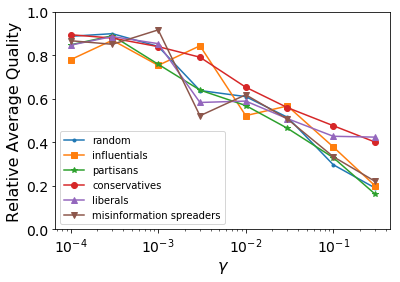

In [58]:
# PLOT AVG_Q vs GAMMA (infiltration) for different TARGETING
bot_model.plot_avg_quality(['gamma_random.csv', 'gamma_hubs.csv', 'gamma_partisans.csv', 'gamma_conservatives.csv', 'gamma_liberals.csv', 'gamma_misinfo.csv'], 
                 ['random', 'influentials', 'partisans', 'conservatives', 'liberals', 'misinformation spreaders'], 
                 r'$\gamma$', path='../EmpiricalNet_followers/', log_flag=True)